**Steps:**
* One-Hot-Encode the label (dim=3)
* Split the dataset into training and validation (80/20%)
* Scale the features to take values between 0 and 1 
    * fit on training dataset and apply the scaler also to the validation set
* Buld the NN:
    * 3 hidden layers with 50, 20 and 10 nodes activated by *ReLU*
    * Output layer with 3 nodes and *Softmax* activation
    * Use *categorical crossentropy* as a loss
    * Ask Maurizio for the optimizer, weight initialization, regularization, dropout
    * For now we can use *Adam* and leave everything else as default
* Create the trainer
    * AEASGD for now is the one with the best performances
* Train the model!

**Optional**
* ... Example of Cross Validation using spark?

## Create a Spark Session

In [1]:
import findspark
findspark.init('/afs/cern.ch/work/m/migliori/public/spark2.3.1/')

In [2]:
application_name = 'dist-keras-notebook'
master = "local[8]"

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .appName("dist-keras")\
        .config("spark.master", master)\
        .config("spark.driver.memory", "32G")\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.local.dir", "/local1/matteo")\
        .config("spark.sql.execution.arrow.enabled", "true")\
        .getOrCreate()

In [4]:
spark

## Load the dataframe

In [9]:
HLF_dataset = spark.read.format("parquet") \
        .load("../converted_data.parquet") \
        .select(['hfeatures', 'label'])
                
HLF_dataset.count()

13359

In [10]:
HLF_dataset.show(5)

+--------------------+-----+
|           hfeatures|label|
+--------------------+-----+
|[405.151287078857...|    1|
|[53.2725028991699...|    1|
|[323.423492431640...|    1|
|[228.913959503173...|    1|
|[149.133995056152...|    1|
+--------------------+-----+
only showing top 5 rows



## Prepare the features

In [12]:
## Converte hfeatures in vector dense 
## The function used to convert returns a list but we need vector dense
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

vector_dense_udf = udf(lambda r : Vectors.dense(r),VectorUDT())
HLF_dataset = HLF_dataset.withColumn('dense_features',vector_dense_udf('hfeatures'))

In [13]:
## Create train and test dataframes
train, test = HLF_dataset.randomSplit([0.8, 0.2])

In [14]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 10644
Events for the validation 2715


In [15]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import MinMaxScaler

## One-Hot-Encode
encoder = OneHotEncoderEstimator(inputCols=["label"],
                                 outputCols=["encoded_label"],
                                 dropLast=False)

## Scale feature vector
scaler = MinMaxScaler(inputCol="dense_features",
                      outputCol="features")

pipeline = Pipeline(stages=[encoder, scaler])

fitted_pipeline = pipeline.fit(train)

In [16]:
## Transform train and test
train = fitted_pipeline.transform(train)
test = fitted_pipeline.transform(test)

train = train.selectExpr('features', 'encoded_label as label')
test = test.selectExpr('features', 'encoded_label as label')

In [17]:
from pyspark.sql.functions import rand 
train = train.orderBy(rand())
train.show(10)

+--------------------+-------------+
|            features|        label|
+--------------------+-------------+
|[0.06422384803769...|(3,[1],[1.0])|
|[0.08844176100717...|(3,[1],[1.0])|
|[0.08582530856002...|(3,[1],[1.0])|
|[0.09050080771232...|(3,[1],[1.0])|
|[0.04713700322079...|(3,[2],[1.0])|
|[0.15846260123142...|(3,[1],[1.0])|
|[0.07650674714152...|(3,[1],[1.0])|
|[0.18692247271153...|(3,[1],[1.0])|
|[0.01456434458980...|(3,[2],[1.0])|
|[0.05388096171980...|(3,[1],[1.0])|
+--------------------+-------------+
only showing top 10 rows



In [30]:
train.groupBy('label').count().show()

+-------------+-----+
|        label|count|
+-------------+-----+
|(3,[2],[1.0])| 4941|
|(3,[1],[1.0])| 5658|
|(3,[0],[1.0])|   45|
+-------------+-----+



As we can see the training dataset in highly unbalanced. 

## Build the Keras model

In [31]:
from keras.optimizers import adam
from keras.models import Sequential
from keras.layers.core import Dense, Activation

Using TensorFlow backend.


In [32]:
model = Sequential()
model.add(Dense(50, input_shape=(14,), activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                750       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 33        
Total params: 2,013
Trainable params: 2,013
Non-trainable params: 0
_________________________________________________________________


## Distributed-Keras trainer

In [33]:
from distkeras.trainers import * 
from distkeras.predictors import *
from distkeras.utils import *
from distkeras.workers import *

In [35]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

num_epochs = 50 
batch_size = 128

## set the number of workers
num_workers = 5

In [36]:
trainer = AEASGD(keras_model=model, worker_optimizer=optimizer,
                 loss=loss, num_workers=num_workers, batch_size=batch_size,
                 features_col="features", label_col="label", num_epoch=num_epochs,
                 communication_window=32, rho=5.0, learning_rate=0.1,
                 master_port=5500)
trainer.set_parallelism_factor(1)

In [37]:
trained_model = trainer.train(train)

In [38]:
print('Training time using AEASGD: {} min' \
      .format(int(trainer.get_training_time()/60)))

Training time using AEASGD: 0 min


We can also try to use another trainer (ADAG): 

In [39]:
trainer_adag = ADAG(keras_model=model, worker_optimizer=optimizer, loss=loss,
                    metrics=["accuracy"], num_workers=num_workers, batch_size=batch_size,
                    features_col="features", label_col="label",
                    num_epoch=num_epochs, communication_window=12,
                    master_port=5600)
trainer_adag.set_parallelism_factor(1)

In [40]:
trained_model_adag = trainer_adag.train(train)

In [41]:
print('Training time using ADAG: {} min' \
      .format(int(trainer_adag.get_training_time()/60)))

Training time using ADAG: 0 min


Dynamic SGD

In [42]:
trainer_dsgd = DynSGD(keras_model=model, worker_optimizer=optimizer, loss=loss,
                      metrics=["accuracy"], num_workers=num_workers, batch_size=batch_size,
                      features_col="features", label_col="label", num_epoch=num_epochs,
                      communication_window=10, master_port=5700)
trainer_dsgd.set_parallelism_factor(1)

In [43]:
trained_model_dsgd = trainer_dsgd.train(train)

Not executed


In [44]:
print('Training time using DynSGD: {} min' \
      .format(int(trainer_dsgd.get_training_time()/60)))

Training time using DynSGD: 1 min


###  Plot workers iterations and Loss

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

In [46]:
worker_id = []
worker_iterations = []
worker_trainer = []

trainers_list = [trainer, trainer_adag, trainer_dsgd]
trainers_name = ['AEASGD', 'ADAG', 'DynSGD']

for t, t_name in zip(trainers_list, trainers_name):
    for i in range(t.get_num_workers()):
        worker_id.append(i)
        worker_iterations.append(len(t.get_executor_history(i)))
        worker_trainer.append(t_name)
        
trainer_dataframe = pd.DataFrame({'worker_id':worker_id,
                                  'worker_iterations':worker_iterations,
                                  'trainer':worker_trainer})
trainer_dataframe.head()

,trainer,worker_id,worker_iterations
0,AEASGD,0,800
1,AEASGD,1,800
2,AEASGD,2,800
3,AEASGD,3,800
4,AEASGD,4,800


<IPython.core.display.Javascript object>


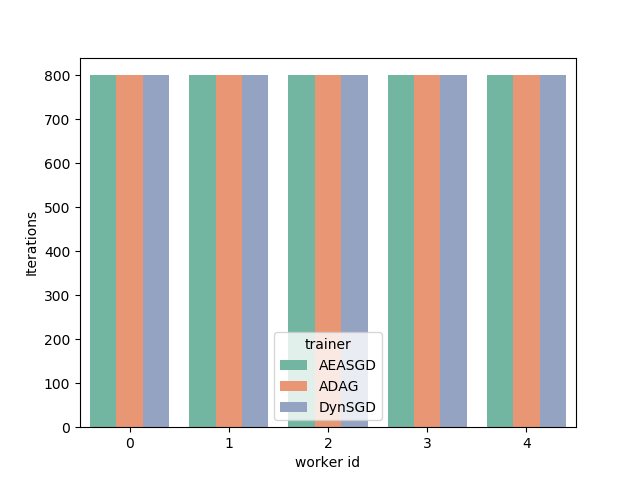

In [47]:
%matplotlib notebook 
plt.figure()
sns.barplot(x='worker_id', y='worker_iterations', hue='trainer',
              data=trainer_dataframe, palette="Set2")
plt.xlabel('worker id')
plt.ylabel('Iterations')
plt.show()

In [48]:
def compute_trainer_metrics(trainer):
    
    ## Get the history of each executor and find the max number of iterations
    num_workers = trainer.get_num_workers()
    max_iterations = 0
    
    history = []
    
    for i in range(num_workers):
        history.append(trainer.get_executor_history(i))
        if history[i][-1]['iteration']>max_iterations:
            max_iterations = history[i][-1]['iteration']
            
    iteration = []
    avg_loss = []
    std_loss = []

    ## Average the losses of batch_size iterations
    batch_loss = []
    batch_std = []
    
    for i in range(max_iterations):
        loss_i = [h[i]['history'][0] for h in history if i<len(h)]
        batch_loss.append(np.mean(loss_i))
        batch_std.append(np.std(loss_i))
    
        if (i%100==0) or (i==max_iterations-1):
            iteration.append(i)
            avg_loss.append(np.mean(batch_loss))
            std_loss.append(np.mean(batch_std))
            batch_loss = []
            batch_std = []
    
    iteration = np.asarray(iteration)
    loss = np.asarray(avg_loss)
    error = np.asarray(std_loss)
    
    return iteration, loss, error

In [49]:
x, y, err = compute_trainer_metrics(trainer)

In [50]:
x_adag, y_adag, err_adag = compute_trainer_metrics(trainer_adag)

In [51]:
x_dsgd, y_dsgd, err_dsgd = compute_trainer_metrics(trainer_dsgd)

<IPython.core.display.Javascript object>


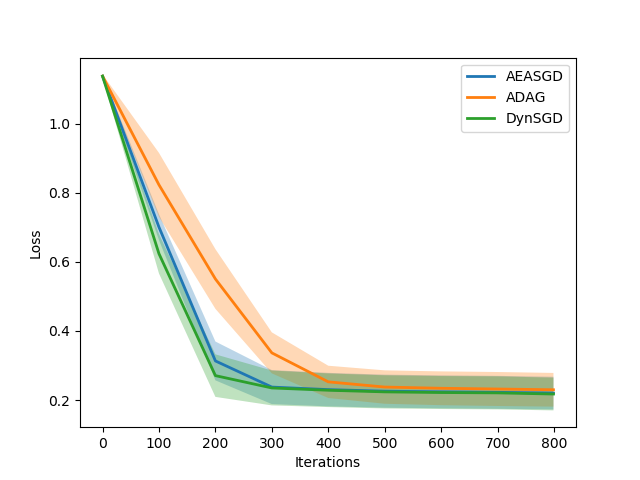

In [53]:
plt.figure()
plt.plot(x, y, lw=2, label='AEASGD')
plt.plot(x_adag, y_adag, lw=2, label='ADAG')
plt.plot(x_dsgd, y_dsgd, lw=2, label='DynSGD')
plt.fill_between(x, y - err , y + err, alpha=0.3)
plt.fill_between(x_adag, y_adag - err_adag,
                 y_adag + err_adag, alpha=0.3)
plt.fill_between(x_dsgd, y_dsgd - err_dsgd,
                 y_dsgd + err_dsgd, alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Save the model

In [74]:
trained_model.save('trained_model.h5')

In [75]:
# as a test, laod the model and use the loaded model 
# to make predictions
from keras.models import load_model
loaded_model = load_model('trained_model.h5')

The model is compiled before the training inside each worker. (Just ignore the warnign)

## Make predictions

In [76]:
predictor = ModelPredictor(keras_model=loaded_model, features_col='features')
pred = predictor.predict(test).cache()

In [77]:
pred.select(['label', 'prediction']).show(5)

+-------------+--------------------+
|        label|          prediction|
+-------------+--------------------+
|(3,[1],[1.0])|[0.00265940255485...|
|(3,[1],[1.0])|[0.00351112359203...|
|(3,[1],[1.0])|[0.01891032420098...|
|(3,[1],[1.0])|[0.01181455608457...|
|(3,[1],[1.0])|[0.00441632280126...|
+-------------+--------------------+
only showing top 5 rows



In [78]:
## Trigger the prediction
pred.count()

2715

## Compute auc for the classes 

In [79]:
%%time
y_pred = np.asarray(pred.select('prediction').rdd\
                    .map(lambda row: np.asarray(row.prediction)).collect())
y_true = np.asarray(pred.select('label').rdd\
                    .map(lambda row: np.asarray(row.label)).collect())

CPU times: user 37.8 ms, sys: 8.16 ms, total: 46 ms
Wall time: 647 ms


Let's try to do te same using pandas:

1. Convert Dense/Sparse vector to numpy arrays
2. Convert the dataframe to pandas

In [80]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('label').alias('label'),
                    vector_udf('prediction').alias('prediction')])

In [81]:
pred.show(5)

+---------------+--------------------+
|          label|          prediction|
+---------------+--------------------+
|[0.0, 1.0, 0.0]|[0.00265940255485...|
|[0.0, 1.0, 0.0]|[0.00351112359203...|
|[0.0, 1.0, 0.0]|[0.01891032420098...|
|[0.0, 1.0, 0.0]|[0.01181455608457...|
|[0.0, 1.0, 0.0]|[0.00441632280126...|
+---------------+--------------------+
only showing top 5 rows



This should be very fast because we enabled `pyarrow` with 

```Python 
config("spark.sql.execution.arrow.enabled", "true")
```

In [82]:
%%time
pred_pd = pred.toPandas()

CPU times: user 8.04 ms, sys: 5.5 ms, total: 13.5 ms
Wall time: 319 ms


In [83]:
pred_pd.head()

,label,prediction
0,"[0.0, 1.0, 0.0]","[0.0026594025548547506, 0.019153041765093803, ..."
1,"[0.0, 1.0, 0.0]","[0.0035111235920339823, 0.03275727853178978, 0..."
2,"[0.0, 1.0, 0.0]","[0.018910324200987816, 0.05061916634440422, 0...."
3,"[0.0, 1.0, 0.0]","[0.011814556084573269, 0.05073307827115059, 0...."
4,"[0.0, 1.0, 0.0]","[0.00441632280126214, 0.04038063809275627, 0.9..."


In [84]:
y_true = np.array(pred_pd['label'].tolist())
y_pred = np.array(pred_pd['prediction'].tolist())

In [85]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

By applying a threshold requirement on $y_W$ or $y_{t\bar{t}}$, one can define a $W$ or $t\bar{t}$ classifier.

* label $QCD$ = 0
* label $t\bar{t}$ = 1
* label $W$ = 2

<IPython.core.display.Javascript object>


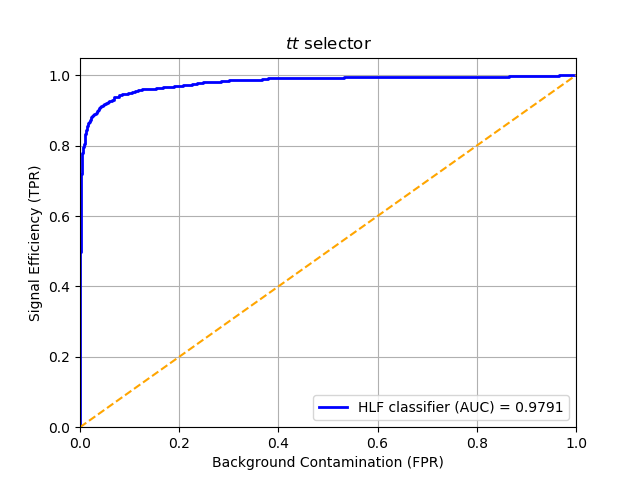

In [86]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


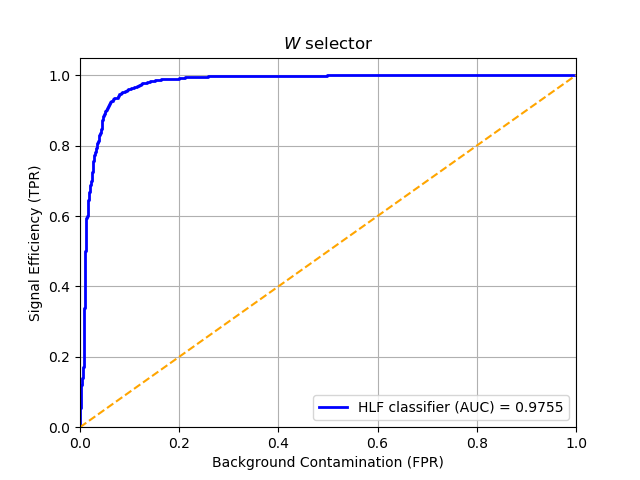

In [87]:
plt.figure()
plt.plot(fpr[2], tpr[2], color='blue',
         lw=2, label='HLF classifier (AUC) = %0.4f' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Plot the confusion matrix

In [88]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9297


<IPython.core.display.Javascript object>


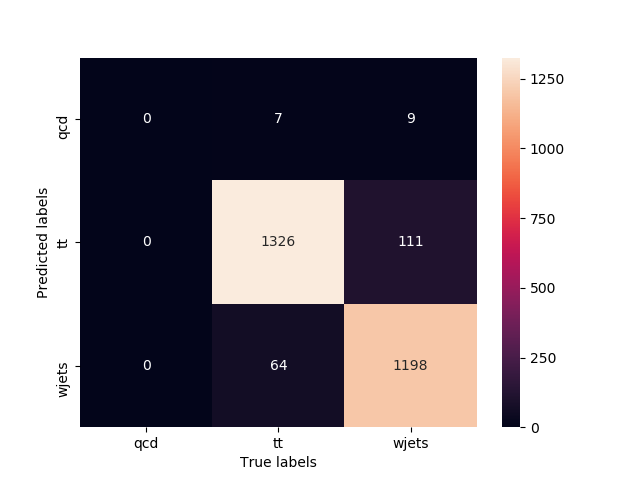

In [89]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [90]:
import pandas as pd

pd.value_counts(np.argmax(y_true, axis=1))

1    1437
2    1262
0      16
dtype: int64